# Inserting subfigures in Pyplot (Mandelbrot too!)

## Inserting subfigures

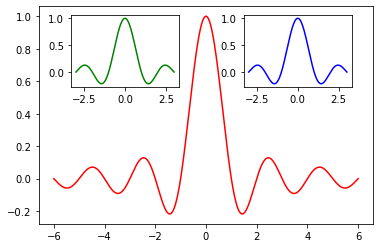

In [1]:
import numpy as np
from matplotlib import pyplot as plt

X = np.linspace(-6, 6, 1024)
Y = np.sinc(X)

X_detail = np.linspace(-3, 3, 1024)
Y_detail = np.sinc(X_detail)

plt.plot(X, Y, c = 'r')

# position lower left corner of 1st internal axis at .6,.6
sub_axes = plt.axes([.6, .6, .25, .25])
sub_axes.plot(X_detail, Y_detail, c = 'b')
# position lower left corner of 2nd internal axis at .2,.6
xsub_axes = plt.axes([.2, .6, .25, .25])
xsub_axes.plot(X_detail, Y_detail, c = 'g')
#plt.setp(sub_axes)

plt.show()

## Mandelbrot  Set

Here we draw the Mandelbrot set on the complex plane using a color map, which is frequently
a useful technize for looking at function values on the complex plane.

For  a discussion of its fractile (self-similarity) properties of the Mandelbrot set.
see the [Wolfram Mathworld page on the Mandelbrot Set](https://mathworld.wolfram.com/MandelbrotSet.html)).
For a spectacular visual demonstration, see this [Mandelbrot Zoom video.](https://www.youtube.com/watch?v=aSg2Db3jF_4)

The Mandelbrot recursion equation is:

$$
z_{n+1} = {z_{n}}^2 + C
$$

A point $C$ is in the Mandelbrot set if the absolute value of $z_n$ does not tend to infinity
when $z_0=C$.  In the code below, we test to see if the absolute value of $z_{n}$ (distance
from the origin) has exceeded a certain value $b$ ( we use $b = 2.0$) after each iteration, and we color a point
according to how many iterations it takes to exceed $b$. Practically speaking, we need a maximum
number of iterations after which we declare victory.  In the code below that value (`max_iter`) is
set to 64.  A point which remains within distance $b$ of the origin after  64 iterations is treated
as being in the set.  More precisely it passes the value 64 to the color map,  which is the
highest possible value a color can get.  On a cool$\rightarrow$warm color map, it will be colored
with the hottest color.

First some matplotlib oriented function to help us label the axes of the image correctly
and to add colorbars.

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

def add_xy_ticks_to_image_axis (ax, X, Y, rotated = False, 
                                complex_plane = False, prec=2,
                                reflectY = True):
    """
    In an image, the i,j coordinates of a point are integer pairs specifying pixel locations.
    At the moment we assume a square NxN image (N^2 pixels).
    
    But when the images are images of the Cartesian or complex planes, those
    (i,j) coordinates correspond to pairs of real number values (x,y).  This
    function relabels the axis to show the (x,y) values.
    
    This should be called after `plt.imshow`.
    """
    xformat = lambda x: f'{x:.{prec}f}'
    yformat = lambda y: f'{y:.{prec}f}i' if complex_plane else xformat
    if rotated:
        #pixel coord (i,j) corresponds to the value assigned (y,x)
        X,Y = Y,X
        xformat,yformat = yformat, xformat
    xmin, xmax, ymin, ymax = np.min(X),np.max(X),np.min(Y),np.max(Y)
    (M,N) = X.shape[0], Y.shape[0]
    it, jt = ax.get_xticks(), ax.get_yticks()   
    it = np.linspace(2, M-2, len(it), dtype = np.int64)
    jt = np.linspace(2, N-2, len(jt), dtype = np.int64)
    # This prevents the matplotlib warning that often accompanies tick relabeling
    ax.set_xticks(it)
    ax.set_yticks(jt)
    il =  [xformat(X[i]) for i in it]
    if reflectY:
      Y = Y[::-1]
    jl =  [yformat(Y[j]) for j in jt]
    ax.set_xticklabels(il)
    ax.set_yticklabels(jl)
    

def add_color_bar (imgplot, ax, pad = 0.05, size = "5%", side="right"):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(side, size=size, pad=pad)
    plt.colorbar(imgplot, cax=cax)   

The next cell contains the function `iter_mandelbrot`, which implements the Mandelbrot recursion
equation and returns the Mandelbrot color value for a point (an integer from 0 to 64).

The next cell also contains the function `compute_mandelbrot_matrix`, which computes the Mandelbrot
values for a entire grid of points, and returns a `numpy` 2D-array suitable for `matplotlib.imshow`.

In [489]:
def iter_mand (C,max_iter,b,julia):
    if julia:
        return iter_julia(C, max_iter, b=b)
    else:
        return iter_mandelbrot(C, max_iter, b=b)

def iter_mandelbrot(C, max_iter, b=2.0): 
  """
  Implements the Mandelbrot recursion equation. C{C} is complex number we are testing.
  
  Returns the Mandelbrot value for C{C}, which is the number
  of recursion steps it takes to move more than distance b from the origin.
  Computation ceases after C{max_iter} recursion steps.
  Therefore the Mandelbrot value is an integer between 0 and C{max_iter}
  
  Effectively we assume that if a point hasn't moved out past 
  distance C{b} within C{max_iter} steps, it is in the set.  
  """
  X = C 
  for n in range(max_iter): 
    if abs(X) > b: 
      return n 
    X = X ** 2 + C 
  return max_iter 

def iter_julia(C, max_iter, b=2.0): 
  """
  Implements the Mandelbrot recursion equation. C{C} is complex number we are testing.
  
  Returns the Mandelbrot value for C{C}, which is the number
  of recursion steps it takes to move more than distance b from the origin.
  Computation ceases after C{max_iter} recursion steps.
  Therefore the Mandelbrot value is an integer between 0 and C{max_iter}
  
  Effectively we assume that if a point hasn't moved out past 
  distance C{b} within C{max_iter} steps, it is in the set.  
  """
  X = C 
  for n in range(max_iter): 
    if abs(X) > b:  
      break
    X = X ** 2 + C 
  return n/max_iter 

def compute_mandelbrot_matrix_r(X, Y, max_iter, reflectX = True,b=2.0,julia=None):
    Z = np.empty((X.shape[0], Y.shape[0]),dtype=np.int64) 
    if reflectX:
        X = X[::-1]
    for i, x in enumerate(X): 
      for j, y in enumerate(Y): 
        Z[i, j] = iter_mand(complex(x, y), max_iter,b=b,julia=julia)
    return Z

def compute_mandelbrot_matrix(X, Y, max_iter, reflectY = True, b=2.0,
                              show_unit_circle = False,julia=False):
    """
    Pixel (i,j) corresponds to (y,x).
    
    The image matrix indexs from the upper left hand corner 
    left to right and down, reflect Y makes the Y vals increase
    from bottom to top (the usual way we look at the Y axis)
    """
    tol = abs(np.max(X)**2 - np.min(X)**2)/10**3
    Z = np.empty((Y.shape[0], X.shape[0]),dtype=np.int64) 
    if reflectY:
        Y = Y[::-1]
    for i, y in enumerate(Y):  # row idx is complex axis coord
        for j, x in enumerate(X): # col idx is real axis coord
            tval = np.sqrt(x**2 + y**2)
            val = max_iter if show_unit_circle and \
                  0 < abs(1 - tval) < tol else iter_mand(complex(x, y), max_iter,b=b,
                                                         julia=julia)
            Z[i, j] = val
    return Z

def compute_matrix_for_mandelbrot_func(func, X, Y, max_iter, b=2.0):
    """
    Pixel (i,j) corresponds to (y,x).
    
    The image matrix indexs from the upper left hand corner 
    left to right and down, reflect Y makes the Y vals increase
    from bottom to top (the usual way we look at the Y axis)
    """
    Z = np.empty((Y.shape[0], X.shape[0]),dtype=np.int64) 
    for i, y in enumerate(Y):  # row idx is complex axis coord
        for j, x in enumerate(X): # col idx is real axis coord
            Z[i, j] = func(complex(x, y), max_iter,b=b)
    return Z

def compute_matrix_for_complex_func(func, X, Y):
    """
    Pixel (i,j) corresponds to (y,x).
    
    The image matrix indexs from the upper left hand corner 
    left to right and down, reflect Y makes the Y vals increase
    from bottom to top (the usual way we look at the Y axis)
    """
    #  We are not putting complex values in here.  funcwill return 
    # a phase or a magnitude
    Z = np.empty((Y.shape[0], X.shape[0])) 
    for i, y in enumerate(Y):  # row idx is complex axis coord
        for j, x in enumerate(X): # col idx is real axis coord
            Z[i, j] = func(complex(x, y))
    return Z

Finally a convenience function that combines function calculation with plotting commands:

In [280]:
import matplotlib.cm as cm
from matplotlib import pyplot as plt 

# Colormaps to try
ranked_cm_list = [cm.RdBu_r, cm.jet_r, cm.RdBu, cm.twilight_shifted_r, cm.copper,
                   cm.gray, cm.turbo, 
                 ]

def get_mandelbrot_matrix(xmin,xmax,N=512,max_iter=64,reflect=True,show_unit_circle=False,
                          rotated=False,b=2.0,julia=False):
   #Plotting boundaries    
    X = np.linspace(xmin, xmax, N) 
    Y = np.linspace(ymin, ymax, N) 
    
    if rotated:
        Z = compute_mandelbrot_matrix_r(X, Y, max_iter,reflectX=reflect,b=b,julia=julia)
    else:
        Z = compute_mandelbrot_matrix(X, Y, max_iter,reflectY=reflect,
                                      show_unit_circle=show_unit_circle,b=b,julia=julia)
    return Z

def plot_mandelbrot_region (xmin,xmax,ymin,ymax,height=10,width=10,max_iter=64,N =512, cmap=None,
                            rotated=False,reflect= True, prec = 4, show_unit_circle=False,
                            b=2.0,color_bar=True,julia=False):
    """
    N: Draw matrix of NxN Mandelbrot values
    max_iter: Iterate max_iter times to compute the Mandelbrot value at each point
    xmin,xmax: Real axis plotting boundaries
    ymin,ymax: imaginary axis plotting boundaries
    """
    
    #Plotting boundaries    
    X = np.linspace(xmin, xmax, N) 
    Y = np.linspace(ymin, ymax, N) 
    
    if rotated:
        Z = compute_mandelbrot_matrix_r(X, Y, max_iter,reflectX=reflect,b=b,julia=julia)
    else:
        Z = compute_mandelbrot_matrix(X, Y, max_iter,reflectY=reflect,
                                      show_unit_circle=show_unit_circle,b=b,julia=julia)

    ########################################################################
    #
    # P l o t t i n g      C o d e
    #
    ########################################################################

    plt.figure(figsize=(width,height))
    #cmaps = (cm.RdBu_r, cm.RdBu, cm.nipy_spectral_r, cm.jet_r)
    if cmap is None:
        cmap = ranked_cm_list[0]
    #imgplot = plt.imshow(Z/scale_down, cmap = cmap)
    imgplot = plt.imshow(Z, cmap = cmap,interpolation="bicubic")

    ax = plt.gca()
    if color_bar:
        add_color_bar (imgplot, ax)
    add_xy_ticks_to_image_axis (ax, X, Y, rotated = rotated, 
                                complex_plane = True, prec=prec) 


### The famous picture

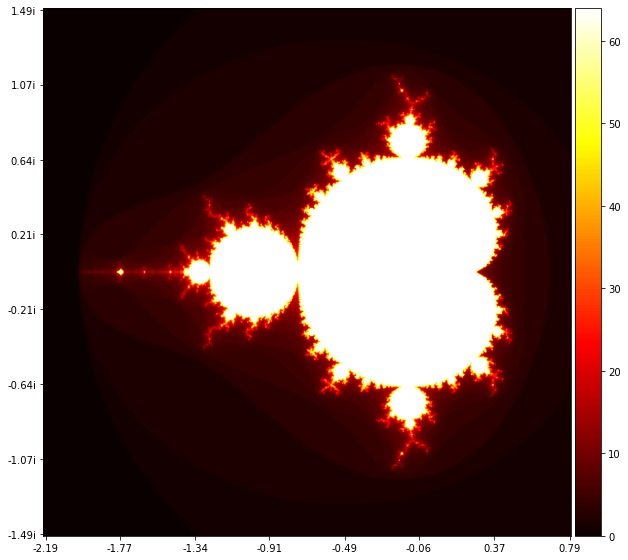

In [51]:
cmap = cm.hot
#cmap = cm.jet_r
#max_iter = 200
max_iter = 64
horizon = 2.0 ** 1
#horizon = 2.0 ** 1
plot_mandelbrot_region (xmin,xmax,ymin,ymax,cmap=cmap, prec=2, show_unit_circle=False,
                        max_iter=max_iter,b=horizon)

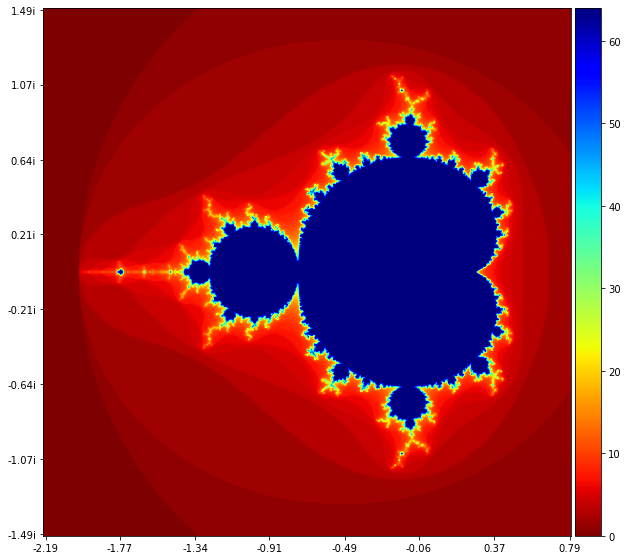

In [52]:
xmin, xmax, ymin, ymax = -2.2, .8, -1.5, 1.5 
# print numbers on axes with precision 2
plot_mandelbrot_region (xmin,xmax,ymin,ymax,cmap=cm.jet_r, prec=2, show_unit_circle=False)

The map looks like a kidney bean  adjoined to circle.   The circle is centered at (-1,0) and has
radius 1/4.  The kidney bean part is bounded by a curve called a cardiod which can be expressed with trigometric
functions. Below we zoom in on the "valley" where the cardioid joins the circle.

The unit circle has been sketched in to show there is no clean relationship between the unit circle and the Mandelbrot set.  Most but not all of the Mandelbrot region lies in the unit circle, and large regions in the interior of the unit circle are not in the Mandelbrot region.  Further changes in color are visible outside the main set body.  These are the boundaries between successive Mandelbrot values, defining a series of what are sometimes called  "Mandelbrot set lemniscates".  

It has been proven that the Mandelbrot set is connected.  As zooming in on it in various places shows,
this is far from obvious.

## Alternate rendering

Inspired by Matplotlib example

First we define a general Mandelbrot set functon, which works
using any function that uses a Mandelbrot style iteraion
(return the number of iterations it takes to exceed a certain
bound for the given function.

We add unb the capacity for shading using a light source.

In [478]:
cmaps = (cm.RdBu_r, cm.RdBu, cm.nipy_spectral_r, cm.jet_r,cm.hot)

cmap_dict = {cm:cm.name for cm in cmaps}


def plot_mandelbrot_function (function,xmin,xmax,ymin,ymax,color_bar=True, max_iter=64, 
                              N=512, b=2.,shading=False,xy_ticks=True,rotated=False,
                              save=False,save_dir = 'mandelbrot_images',color_map_index=0,
                              shading_color_map_index=-1,log_mapping=False,reflectY=False):
    #global fn
    #max_iter, N = 64, 512
    #xmin, xmax, ymin, ymax = -2.2, 2.1, -2.15, 2.15
    #xmin, xmax, ymin, ymax = -.96, -.35, -.3071, .3071

    height, width = 10, 10
    X = np.linspace(xmin, xmax, N) 
    Y = np.linspace(ymin, ymax, N) 
    if reflectY:
        Y = Y[::-1]
 
    Z = compute_matrix_for_mandelbrot_func(function, X, Y, max_iter, b=b)
    #Z = np.empty((N,N))
    # 
    #for i, y in enumerate(Y): 
    #  for j, x in enumerate(X): 
    #    Z[i, j] = function(complex(x, y), max_iter,b=b)

    fig = plt.figure(figsize=(width,height))

    #xticks = np.linspace(xmin, xmax, 20) 
    #yticks = np.linspace(ymin, ymax, 20) 
    
    if shading:
        
        if log_mapping:
         # best with max_iter = 200, b = 2**40
         log_horizon = np.log2(np.log(b))
         with np.errstate(invalid='ignore'):
            Z = np.nan_to_num(N + 1 - np.log2(np.log(abs(Z))) + log_horizon)

        # Shaded rendering
        light = colors.LightSource(azdeg=315, altdeg=10)
        cmap = cmaps[shading_color_map_index]
        norm = colors.PowerNorm(0.3)
        M = light.shade(Z, cmap=cmap, vert_exag=1.5,
                norm=norm, blend_mode='hsv')
        #plt.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
        imgplot = plt.imshow(M,interpolation="bicubic",cmap=cmap)
        #ax = plt.gca()
        #add_color_bar (imgplot, ax)
        #color_bar,xy_ticks = False,False
        xy_ticks = False
    else:
        #colors.PowerNorm(0.3)
        norm = mpl.colors.Normalize(vmin=0, vmax=max_iter)
        cmap = cmaps[color_map_index]
        imgplot = plt.imshow(Z, cmap = cmap)
        
    ax, complex_plane, prec = plt.gca(), True, 4
    if xy_ticks:
        add_xy_ticks_to_image_axis (ax, X, Y, rotated = rotated, 
                                    complex_plane = complex_plane, prec=prec)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    if color_bar:
        pass
        add_color_bar (imgplot, ax)
        # Does not size color bar to current ax (done by stealing some of the axis
        # apce for a color bar)
        #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    if save:
        def print_rep(nums):
            return '_'.join(['']+[f'{round(num*100):d}' for num in nums])

        shade_suff = '_shading' if shading else ''
        log_suff = '_log_mapped' if log_mapping else ''
        border_suff = print_rep([xmin,xmax,ymin,ymax])
        cmap_suff = f'_{cmap.name}'
        func_suff = function.__name__
        save_dir = os.path.join(os.getcwd(),save_dir)
        fn = f'{save_dir}/{func_suff}{cmap_suff}{shade_suff}{log_suff}{border_suff}.png'
        plt.savefig(fn)
        
        
def plot_complex_function (function,xmin,xmax,ymin,ymax,color_bar=True, max_iter=64, 
                              N=512, b=2.,shading=False,xy_ticks=True,rotated=False,
                              save=False,save_dir = 'mandelbrot_images',color_map_index=0,
                              shading_color_map_index=-1,log_mapping=False,reflectY=False):
    #global fn
    #max_iter, N = 64, 512
    #xmin, xmax, ymin, ymax = -2.2, 2.1, -2.15, 2.15
    #xmin, xmax, ymin, ymax = -.96, -.35, -.3071, .3071

    height, width = 10, 10
    X = np.linspace(xmin, xmax, N) 
    Y = np.linspace(ymin, ymax, N) 
    if reflectY:
        Y = Y[::-1]
 
    Z = compute_matrix_for_complex_func(function, X, Y)
    #Z = np.empty((N,N))
    # 
    #for i, y in enumerate(Y): 
    #  for j, x in enumerate(X): 
    #    Z[i, j] = function(complex(x, y), max_iter,b=b)

    fig = plt.figure(figsize=(width,height))

    #xticks = np.linspace(xmin, xmax, 20) 
    #yticks = np.linspace(ymin, ymax, 20) 
    
    if shading:
        
        if log_mapping:
         # best with max_iter = 200, b = 2**40
         log_horizon = np.log2(np.log(b))
         with np.errstate(invalid='ignore'):
            Z = np.nan_to_num(N + 1 - np.log2(np.log(abs(Z))) + log_horizon)

        # Shaded rendering
        light = colors.LightSource(azdeg=315, altdeg=10)
        cmap = cmaps[shading_color_map_index]
        norm = colors.PowerNorm(0.3)
        M = light.shade(Z, cmap=cmap, vert_exag=1.5,
                norm=norm, blend_mode='hsv')
        #plt.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
        imgplot = plt.imshow(M,interpolation="bicubic",cmap=cmap)
        #ax = plt.gca()
        #add_color_bar (imgplot, ax)
        #color_bar,xy_ticks = False,False
        xy_ticks = False
    else:
        #colors.PowerNorm(0.3)
        norm = mpl.colors.Normalize(vmin=0, vmax=max_iter)
        cmap = cmaps[color_map_index]
        imgplot = plt.imshow(Z, cmap = cmap)
        
    ax, complex_plane, prec = plt.gca(), True, 4
    if xy_ticks:
        add_xy_ticks_to_image_axis (ax, X, Y, rotated = rotated, 
                                    complex_plane = complex_plane, prec=prec)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    if color_bar:
        pass
        add_color_bar (imgplot, ax)
        # Does not size color bar to current ax (done by stealing some of the axis
        # apce for a color bar)
        #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    if save:
        def print_rep(nums):
            return '_'.join(['']+[f'{round(num*100):d}' for num in nums])
        
        shade_suff = '_shading' if shading else ''
        log_suff = '_log_mapped' if log_mapping else ''
        border_suff = print_rep([xmin,xmax,ymin,ymax])
        cmap_suff = f'_{cmap.name}'
        func_suff = function.__name__
        save_dir = os.path.join(os.getcwd(),save_dir)
        fn = f'{save_dir}/{func_suff}{cmap_suff}{shade_suff}{log_suff}{border_suff}.png'
        plt.savefig(fn)
        



In [472]:
# import time
# import matplotlib
# from matplotlib import colors
# import matplotlib.pyplot as plt

# #xmin, xmax, ymin, ymax = -2.2, .8, -1.5, 1.5 
# xmin, xmax, ymin, ymax = -3.2, 2.3, -2.5, 2.5 
# dpi = 72
# width = 10
# #height = 10*N/N
# height = 10
# fig = plt.figure(figsize=(width, height), dpi=dpi)
# ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)

# max_iter = 200
# horizon = 2.0 ** 40
# #max_iter = 64
# #horizon = 2.0 #**10
# Z = get_mandelbrot_matrix(xmin,xmax,max_iter=max_iter,b=horizon)
# # Shaded rendering, the original attempt my be the best (for structural sharpness)
# light = colors.LightSource(azdeg=315, altdeg=10)
# # softening effect, but may lost some of the strural definition
# #light = colors.LightSource(azdeg=110, altdeg=10)
# # A nice compromise
# #light = colors.LightSource(azdeg=210, altdeg=10)
# M = light.shade(Z, cmap=plt.cm.hot, vert_exag=1.5,
#                 norm=colors.PowerNorm(0.3), blend_mode='hsv')
# ax.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
# #ax.set_xticks([])
# #ax.set_yticks([])

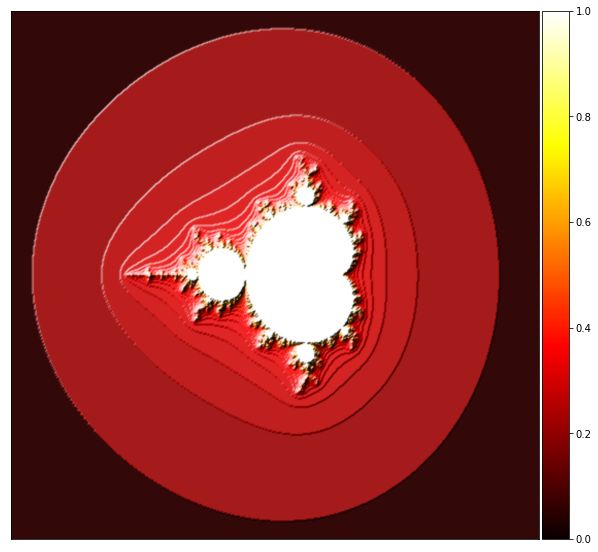

In [471]:
def mandelbrot(C, max_iter,b=2.): 
  X = C 
  for n in range(max_iter): 
    if abs(X) > b: 
      return n 
    X = X ** 2 + C 
  return max_iter 

max_iter = 64
#xmin, xmax, ymin, ymax = -.9, .9, -1.2, 1.2
xmin, xmax, ymin, ymax = -3.2, 2.3, -2.5, 2.5 
shading_color_map_index,color_map_index,color_bar = -1,0,True
max_iter,b,log_mapping,shading = 200,2.0**20,False,True
#max_iter,b,log_mapping,shading = 200,2.0**40,-1,True,True
#max_iter,b,log_mapping,shading,color_map_index = 64,2.,False,False,0
plot_mandelbrot_function (mandelbrot, xmin,xmax,ymin,ymax,shading=shading,
                         color_map_index=color_map_index, color_bar=color_bar,
                         shading_color_map_index = shading_color_map_index,
                         max_iter=max_iter,b=b,log_mapping=log_mapping,
                         save = save)

Note the color semantics.  The color map used above
is a color map called **hot**: black is very cold, red is hot,
white is the hottest.  So the points with the highest numerical value are  in the white region in the center.  In this case, *high value* means the maximum number of iterations was reached, meaning the sequence values remained within the 
given bound for all trials, which we take to mean the sequence is bounded, and does not march off to infinity.

So the white points are **in** the Mandelbrot set; all others exceeded the bound while
the sequence was being computed.  The gradations in color then tell us somethin about quickly they exceeded the bound.  The black points in the exterior all exceeded the bound
very quickly.

[]

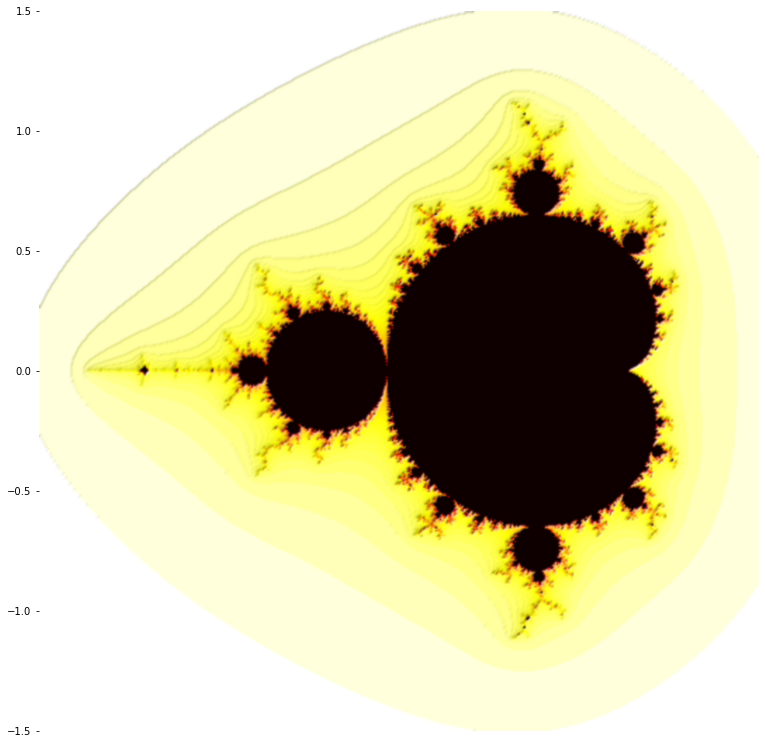

In [99]:
import time
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt

xmin, xmax, ymin, ymax = -2.2, .8, -1.5, 1.5 
dpi = 72
width = 10
#height = 10*N/N
height = 10
N = 512
fig = plt.figure(figsize=(width, height), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)

max_iter = 200
horizon = 2.0 ** 40
log_horizon = np.log2(np.log(horizon))
Z = get_mandelbrot_matrix(xmin,xmax,max_iter=max_iter,b=horizon)
with np.errstate(invalid='ignore'):
    M = np.nan_to_num(N + 1 - np.log2(np.log(abs(Z))) + log_horizon)
# Shaded rendering
light = colors.LightSource(azdeg=315, altdeg=10)
M = light.shade(M, cmap=plt.cm.hot, vert_exag=1.5,
                norm=colors.PowerNorm(0.5), blend_mode='hsv')
ax.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
ax.set_xticks([])
#ax.set_yticks([])

Here's the code for [the matplotlib demo](https://matplotlib.org/stable/gallery/showcase/mandelbrot.html#sphx-glr-gallery-showcase-mandelbrot-py) the images above were inspired by.

<ipython-input-53-2cb3172d1b4a>:36: RuntimeWarning: overflow encountered in log
  M = np.nan_to_num(N + 1 - np.log2(np.log(abs(Z))) + log_horizon)


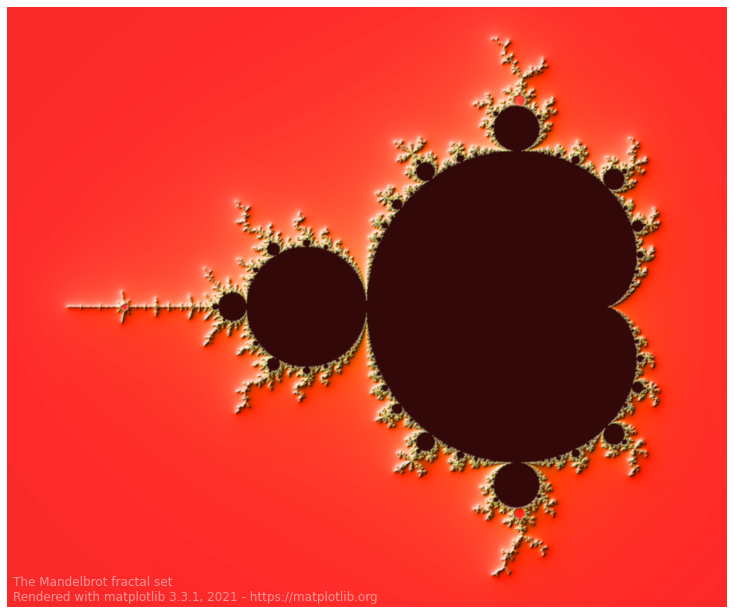

In [53]:
import time
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt


def mandelbrot_set(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon=2.0):
    X = np.linspace(xmin, xmax, xn).astype(np.float32)
    Y = np.linspace(ymin, ymax, yn).astype(np.float32)
    C = X + Y[:, None] * 1j
    N = np.zeros_like(C, dtype=int)
    Z = np.zeros_like(C)
    for n in range(maxiter):
        I = abs(Z) < horizon
        N[I] = n
        Z[I] = Z[I]**2 + C[I]
    N[N == maxiter-1] = 0
    return Z, N



xmin, xmax, xn = -2.25, +0.75, 3000 // 2
ymin, ymax, yn = -1.25, +1.25, 2500 // 2
maxiter = 200
horizon = 2.0 ** 40
log_horizon = np.log2(np.log(horizon))
Z, N = mandelbrot_set(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon)

# Normalized recount as explained in:
# https://linas.org/art-gallery/escape/smooth.html
# https://web.archive.org/web/20160331171238/https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en

# This line will generate warnings for null values but it is faster to
# process them afterwards using the nan_to_num
with np.errstate(invalid='ignore'):
    M = np.nan_to_num(N + 1 - np.log2(np.log(abs(Z))) + log_horizon)

dpi = 72
width = 10
height = 10*yn/xn
fig = plt.figure(figsize=(width, height), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)

# Shaded rendering
light = colors.LightSource(azdeg=315, altdeg=10)
M = light.shade(M, cmap=plt.cm.hot, vert_exag=1.5,
                norm=colors.PowerNorm(0.3), blend_mode='hsv')
ax.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
ax.set_xticks([])
ax.set_yticks([])

# Some advertisement for matplotlib
year = time.strftime("%Y")
text = ("The Mandelbrot fractal set\n"
        "Rendered with matplotlib %s, %s - https://matplotlib.org"
        % (matplotlib.__version__, year))
ax.text(xmin+.025, ymin+.025, text, color="white", fontsize=12, alpha=0.5)

plt.show()

## Sea Horse Valley

We zoom in on a region of the Mandelbrot set known as SeaHorse Valley.  The center of Sea Horse Valley is located at approximately -0.75+0.1i.

The is a region where the "self-similarity" property can be easily seen.  We see repeated sea-horse shaped boundaries on the set.  Each  individual "sea horse" has
sea horses growing out of it. Likewise, each of those sea horse appendages has 
sea horse growths on it.  And so on.

The key point is that the "zoom' is done by simply re-computing the set for a much smaller region of the plane (the rectangle boundaries are reset).  This isn't a blow-up of the original image.  It couldn't be, because the pixels don't have enough information to show the structure we see below.

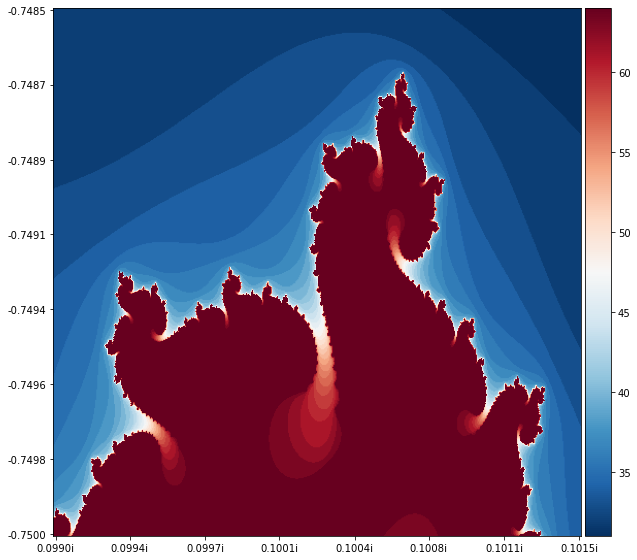

In [45]:
xmin, xmax, ymin, ymax = -.750, -.7485, .099, .1015
# We're rotating this picture for a better view of the sea horses, also printing imaginary axis downward
# increasing.
plot_mandelbrot_region (xmin,xmax,ymin,ymax,rotated= True,cmap=cm.RdBu_r,reflect=False)

## Elephant Valley

Here's another region with different structures known as elephant valley

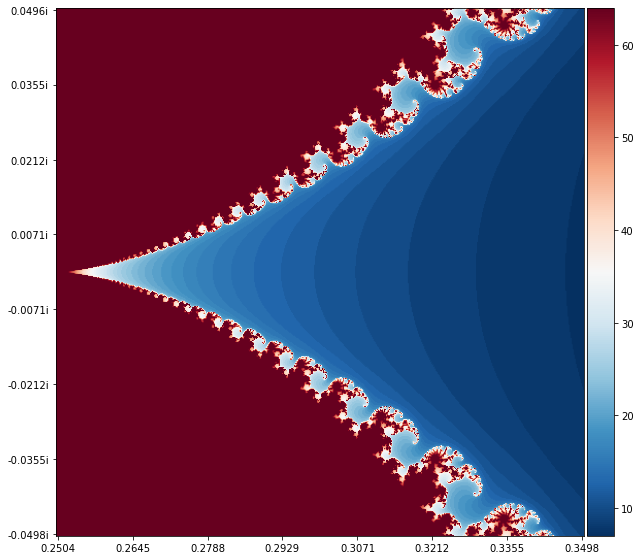

In [41]:
# 0.3+0i. elephant valley center

xmin, xmax, ymin, ymax = .25, .35, -.05, .05
plot_mandelbrot_region (xmin,xmax,ymin,ymax,cmap=cm.RdBu_r)

Now we zoom in a trunk-filled part of elephant valley.

It took some trial and error to point the "camera" at the rIght part of the plane.

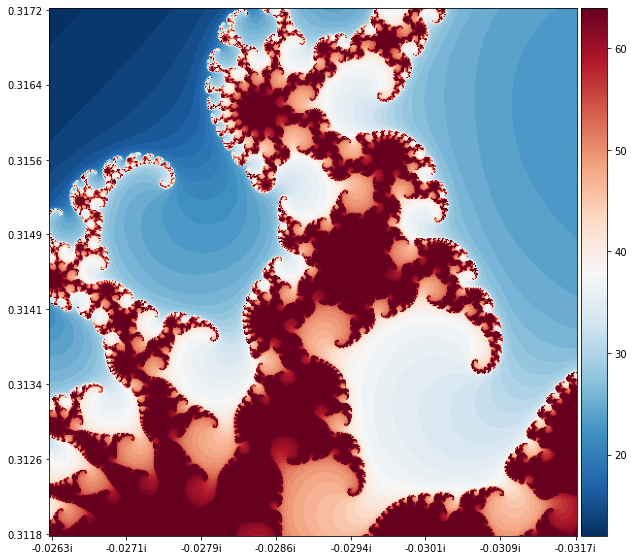

In [61]:

# elephant valley zoom

#xmin, xmax, ymin, ymax = .3080, .3085, -.03200, -.03205 white
#xmin, xmax, ymin, ymax = .3070, .3075, -.03275, -.03325 white
#xmin, xmax, ymin, ymax = .300, .340, -.035, -.031 #structure, left side
#xmin, xmax, ymin, ymax = .29, .33, -.02, -.04  #is Good!
#xmin, xmax, ymin, ymax = .3071, .3185, -.0258, -.0342  # good shot adjusting
xmin, xmax, ymin, ymax = .3118, .3172, -.0263, -.0317 # 
plot_mandelbrot_region (xmin, xmax, ymin, ymax, rotated=True, cmap=cm.RdBu_r)

## Changing the function 1: Cubic Mandelbrot

The idea of the Mendelbrot function  can be carried over to other operations

Suppose instead of iteratively squaring,

$$
z_{n+1} = {z_{n}}^2 + C
$$


We take the cube

$$
z_{n+1} = {z_{n}}^3 + C
$$

Here's what we get, the Mandelbrot insect.

In [465]:
def cubic_mandelbrot(C, max_iter,b=2.): 
  X = C 
  for n in range(max_iter): 
    if abs(X) > b: 
      return n 
    X = X ** 3 + C 
  return max_iter 

In [473]:
# max_iter, N = 64, 512
# #xmin, xmax, ymin, ymax = -2.2, .8, -1.5, 1.5 
# xmin, xmax, ymin, ymax = -.9, .9, -1.2, 1.2
# height, width = 10, 10
# X = np.linspace(xmin, xmax, N) 
# Y = np.linspace(ymin, ymax, N) 


# Z = np.empty((N,N))
# Y = Y[::-1]
# for i, y in enumerate(Y): 
#   for j, x in enumerate(X): 
#     Z[i, j] = cubic_mandelbrot(complex(x, y), max_iter)

# plt.figure(figsize=(width,height))

# #xticks = np.linspace(xmin, xmax, 20) 
# #yticks = np.linspace(ymin, ymax, 20) 
# cmaps = (cm.RdBu_r, cm.RdBu, cm.nipy_spectral_r, cm.jet_r,cm.hot)
# imgplot = plt.imshow(Z, cmap = cmaps[-3])

# ax, rotated, complex_plane, prec = plt.gca(), False, True, 4
# add_color_bar (imgplot, ax)
# add_xy_ticks_to_image_axis (ax, X, Y, rotated = rotated, 
#                             complex_plane = complex_plane, prec=prec)
#JMG Other colormaps to try
#cmap = cm.jet
# cmap = cm.gray
#cmap = cm.hot
#plt.imshow(Z, cmap = cmap)
#ax = plt.gca()
#xt,yt = ax.get_xticks(),ax.get_yticks()
#xl = [f'{x:.1f}' for x in np.linspace(xmin, xmax, len(xt))]
#yl = [f'{y:.1f}' for y in np.linspace(ymin, ymax, len(yt))]
# Attempt to banish warning.  Causes display issue.
#ax.set_xticks(ax.get_xticks())
#ax.set_xticklabels(zip(ax.get_xticks(),xl))
#ax.set_xticklabels(xl)
#ax.set_yticks(ax.get_yticks())
#ax.set_yticklabels(yl)
#plt.show()

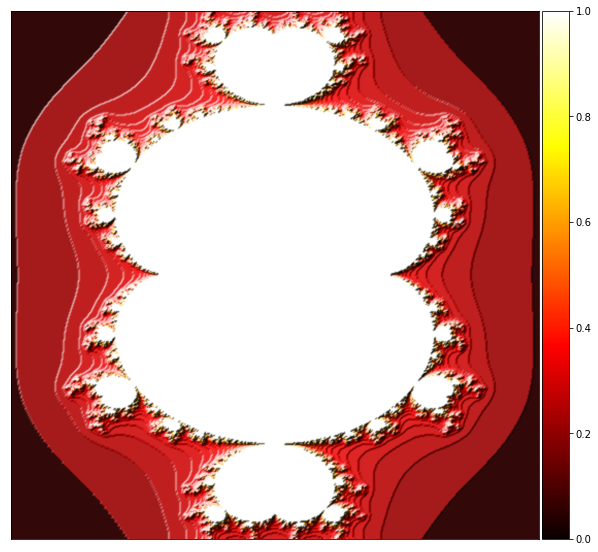

In [469]:
max_iter = 64
xmin, xmax, ymin, ymax = -.9, .9, -1.2, 1.2
shading_color_map_index,color_map_index,color_bar = -1,0,True
max_iter,b,log_mapping,shading = 200,2.0**20,False,True
#max_iter,b,log_mapping,shading = 200,2.0**40,-1,True,True
#max_iter,b,log_mapping,shading,color_map_index = 64,2.,False,False,0
plot_mandelbrot_function (cubic_mandelbrot, xmin,xmax,ymin,ymax,shading=shading,
                         color_map_index=color_map_index, color_bar=color_bar,
                         shading_color_map_index = shading_color_map_index,
                         max_iter=max_iter,b=b,log_mapping=log_mapping,
                         save = save)

## Changing the function II: Mandelbrot set using sin

This one takes a while!

<ipython-input-346-0d2455179220>:6: RuntimeWarning: overflow encountered in sin
  X = np.sin(X/C)


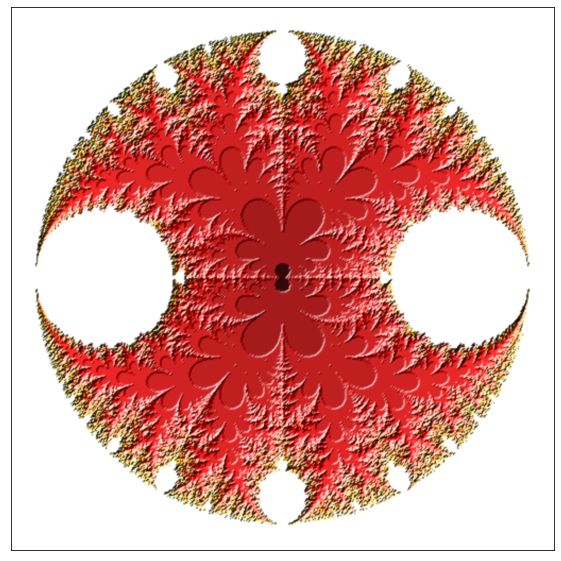

In [346]:
def sin_mandelbrot(C, max_iter,b=2.0): 
  X = C 
  for n in range(max_iter): 
    if abs(X) > b: 
      return n 
    X = np.sin(X/C)
  return max_iter 

# cmaps = (cm.RdBu_r, cm.RdBu, cm.nipy_spectral_r, cm.jet_r,cm.hot)

# cmap_dict = {cm:cm.name for cm in cmaps}


# def plot_mandelbrot_function (function,xmin,xmax,ymin,ymax,color_bar=True, max_iter=64, 
#                               N=512, b=2.,shading=False,xy_ticks=True,rotated=False,
#                               save=False,save_dir = 'mandelbrot_images',color_map_index=0,
#                               shading_color_map_index=-1,log_mapping=False,reflectY=False):
#     #global fn
#     #max_iter, N = 64, 512
#     #xmin, xmax, ymin, ymax = -2.2, 2.1, -2.15, 2.15
#     #xmin, xmax, ymin, ymax = -.96, -.35, -.3071, .3071

#     height, width = 10, 10
#     X = np.linspace(xmin, xmax, N) 
#     Y = np.linspace(ymin, ymax, N) 
#     if reflectY:
#         Y = Y[::-1]
 
#     Z = compute_matrix_for_mandelbrot_func(function, X, Y, max_iter, b=b)
#     #Z = np.empty((N,N))
#     # 
#     #for i, y in enumerate(Y): 
#     #  for j, x in enumerate(X): 
#     #    Z[i, j] = function(complex(x, y), max_iter,b=b)

#     fig = plt.figure(figsize=(width,height))

#     #xticks = np.linspace(xmin, xmax, 20) 
#     #yticks = np.linspace(ymin, ymax, 20) 
    
#     if shading:
        
#         if log_mapping:
#          # best with max_iter = 200, b = 2**40
#          log_horizon = np.log2(np.log(b))
#          with np.errstate(invalid='ignore'):
#             Z = np.nan_to_num(N + 1 - np.log2(np.log(abs(Z))) + log_horizon)

#         # Shaded rendering
#         light = colors.LightSource(azdeg=315, altdeg=10)
#         cmap = cmaps[shading_color_map_index]
#         norm = colors.PowerNorm(0.3)
#         M = light.shade(Z, cmap=cmap, vert_exag=1.5,
#                 norm=norm, blend_mode='hsv')
#         #plt.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
#         imgplot = plt.imshow(M,interpolation="bicubic",cmap=cmap)
#         #ax = plt.gca()
#         #add_color_bar (imgplot, ax)
#         #color_bar,xy_ticks = False,False
#         xy_ticks = False
#     else:
#         #colors.PowerNorm(0.3)
#         norm = mpl.colors.Normalize(vmin=0, vmax=max_iter)
#         cmap = cmaps[color_map_index]
#         imgplot = plt.imshow(Z, cmap = cmap)
        
#     ax, complex_plane, prec = plt.gca(), True, 4
#     if xy_ticks:
#         add_xy_ticks_to_image_axis (ax, X, Y, rotated = rotated, 
#                                     complex_plane = complex_plane, prec=prec)
#     else:
#         ax.set_xticks([])
#         ax.set_yticks([])
#     if color_bar:
#         pass
#         add_color_bar (imgplot, ax)
#         # Does not size color bar to current ax (done by stealing some of the axis
#         # apce for a color bar)
#         #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#     if save:
#         def print_rep(nums):
#             return '_'.join(['']+[f'{round(num*100):d}' for num in nums])
        
#         shade_suff = '_shading' if shading else ''
#         log_suff = '_log_mapped' if log_mapping else ''
#         border_suff = print_rep([xmin,xmax,ymin,ymax])
#         cmap_suff = f'_{cmap.name}'
#         func_suff = function.__name__
#         save_dir = os.path.join(os.getcwd(),save_dir)
#         fn = f'{save_dir}/{func_suff}{cmap_suff}{shade_suff}{log_suff}{border_suff}.png'
#         plt.savefig(fn)
        

# lots of white around the centrral structure, zoomed out too far.
#xmin, xmax, ymin, ymax = -2.2, 2.1, -2.15, 2.15
xmin, xmax, ymin, ymax = -1.1, 1.1, -1.1, 1.1


save=False
# Background/default values for initialization, sometimes omitted in the configs below
color_bar, color_map_index,shading_color_map_index = False,0,-1
#max_iter,b,color_map_index,log_mapping,shading = 64,2.0,-3,False,False
# -3 works, -1 is very cool
max_iter,b,shading_color_map_index,log_mapping,shading = 200,2.0**20,-1,False,True
#max_iter,b,shading_color_map_index,log_mapping,shading = 200,2.0**40,-1,True,True
#max_iter,b,log_mapping,shading,color_map_index = 64,2.,False,False,0
plot_mandelbrot_function (sin_mandelbrot, xmin,xmax,ymin,ymax,shading=shading,
                         color_map_index=color_map_index, color_bar=color_bar,
                         shading_color_map_index = shading_color_map_index,
                         max_iter=max_iter,b=b,log_mapping=log_mapping,
                         save = save)


## Mandelbrot Cosine

The `cosine` variant is particularly interesting. Let's do that with some zooms.

<ipython-input-365-4fb7938943f1>:16: RuntimeWarning: overflow encountered in cos
  X = np.cos(X*C)


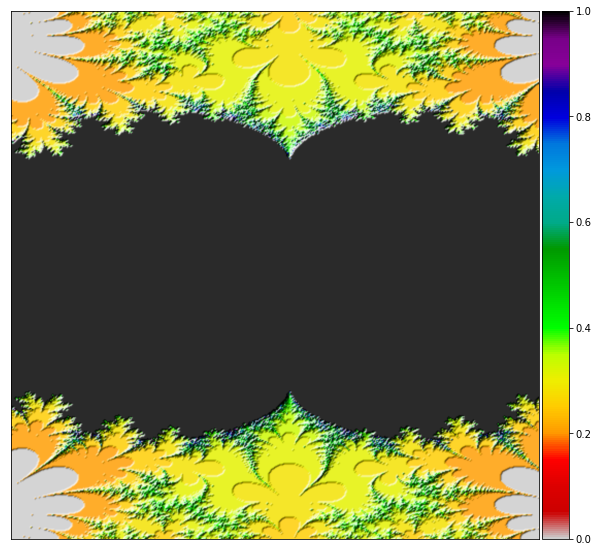

In [365]:
import os.path

def cos_mandelbrot(C, max_iter,b=2.): 
  X = C 
  for n in range(max_iter): 
    if abs(X) > b: 
      return n 
    X = np.cos(X/C)
  return max_iter 

def cos_mandelbrot_prod(C, max_iter,b=2.): 
  X = C 
  for n in range(max_iter): 
    if abs(X) > b: 
      return n 
    X = np.cos(X*C)
  return max_iter 

#cmaps = (cm.RdBu_r, cm.RdBu, cm.nipy_spectral_r, cm.jet_r,cm.hot)

#cmap_dict = {cm:cm.name for cm in cmaps}

# def plot_mandelbrot_function (function,xmin,xmax,ymin,ymax,color_bar=True, max_iter=64, 
#                               N=512, b=2.,shading=False,xy_ticks=True,rotated=False,
#                               save=False,save_dir = 'mandelbrot_images',color_map_index=0,
#                               shading_color_map_index=-1,log_mapping=False):
#     #global fn
#     #max_iter, N = 64, 512
#     #xmin, xmax, ymin, ymax = -2.2, 2.1, -2.15, 2.15
#     #xmin, xmax, ymin, ymax = -.96, -.35, -.3071, .3071

#     height, width = 10, 10
#     X = np.linspace(xmin, xmax, N) 
#     Y = np.linspace(ymin, ymax, N) 


#     Z = np.empty((N,N))
#     Y = Y[::-1]
#     for i, y in enumerate(Y): 
#       for j, x in enumerate(X): 
#         Z[i, j] = function(complex(x, y), max_iter,b=b)

#     plt.figure(figsize=(width,height))

#     #xticks = np.linspace(xmin, xmax, 20) 
#     #yticks = np.linspace(ymin, ymax, 20) 
    
    
    
#     if shading:
        
#         if log_mapping:
#          # best with max_iter = 200, b = 2**40
#          log_horizon = np.log2(np.log(b))
#          with np.errstate(invalid='ignore'):
#             Z = np.nan_to_num(N + 1 - np.log2(np.log(abs(Z))) + log_horizon)

#         # Shaded rendering
#         light = colors.LightSource(azdeg=315, altdeg=10)
#         cmap = cmaps[shading_color_map_index]
#         M = light.shade(Z, cmap=cmap, vert_exag=1.5,
#                 norm=colors.PowerNorm(0.3), blend_mode='hsv')
#         #plt.imshow(M, extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
#         imgplot = plt.imshow(M,interpolation="bicubic",cmap=cmap)
#         color_bar,xy_ticks = False,False
#     else:
#         cmap = cmaps[color_map_index]
#         imgplot = plt.imshow(Z, cmap = cmap)
#     ax, complex_plane, prec = plt.gca(), True, 4
#     if color_bar:
#         add_color_bar (imgplot, ax)
#     if xy_ticks:
#         add_xy_ticks_to_image_axis (ax, X, Y, rotated = rotated, 
#                                     complex_plane = complex_plane, prec=prec)
#     else:
#         ax.set_xticks([])
#         ax.set_yticks([])
#     if save:
#         def print_rep(nums):
#             return '_'.join(['']+[f'{round(num*100):d}' for num in nums])
        
#         shade_suff = '_shading' if shading else ''
#         log_suff = '_log_mapped' if log_mapping else ''
#         border_suff = print_rep([xmin,xmax,ymin,ymax])
#         cmap_suff = f'_{cmap.name}'
#         func_suff = function.__name__
#         save_dir = os.path.join(os.getcwd(),save_dir)
#         fn = f'{save_dir}/{func_suff}{cmap_suff}{shade_suff}{log_suff}{border_suff}.png'
#         plt.savefig(fn)
        

plot = True
if plot:
    #xmin, xmax, ymin, ymax = -2.2, 2.1, -2.15, 2.15
    #ideal for cos_mandelbrot
    xmin, xmax, ymin, ymax = -.97, .87, -1.53, 1.53
    #xmin, xmax, ymin, ymax = -2.97, 2.87, -3.53, 3.53
    # To try # without log map lots of overflow warnings and a cool pic
    # With log map also cool; default shaded color map (-1) works, also -2
    save = True
    shading_color_map_index,color_map_index,color_bar = -3,-1, False
    # b= 2**2 definitely less cool than  b=2**40
    max_iter,b,shading_color_map_index,log_mapping,shading = 200,2.0**40,-3,False,True
    #max_iter,b,shading_color_map_index,log_mapping,shading = 200,2.0**40,-1,True,True
    #max_iter,b,log_mapping,shading,color_map_index = 64,2.,False,False,0
    plot_mandelbrot_function (cos_mandelbrot_prod, xmin,xmax,ymin,ymax,shading=shading,
                            color_map_index=color_map_index, save = save,
                            shading_color_map_index = shading_color_map_index,
                            max_iter=max_iter,b=b,log_mapping=log_mapping)
    


This one could perhaps be improved by mapping to the log scale.

In [353]:
f'{2**10:_}'

'1_024'

<ipython-input-222-90c2edde3ef8>:8: RuntimeWarning: overflow encountered in cos
  X = np.cos(X/C)


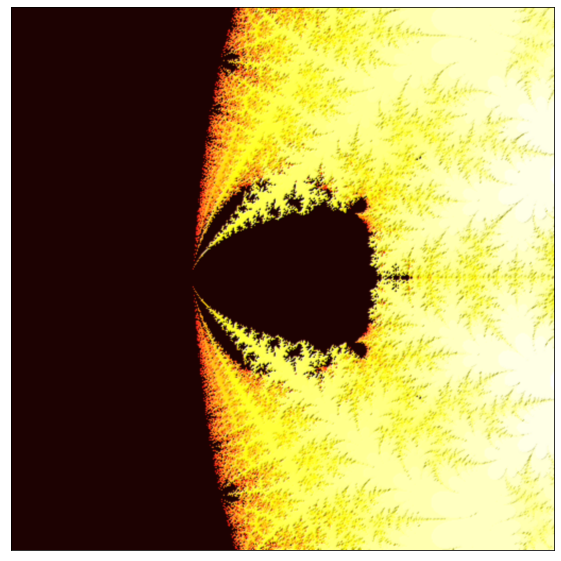

In [223]:
xmin, xmax, ymin, ymax = -.96, -.35, -.3071, .3071
max_iter,b,log_mapping,shading = 200,2.0**40,True,True
plot_mandelbrot_function (cos_mandelbrot,xmin,xmax,ymin,ymax,shading=True,color_map_index=-2,
                        max_iter=max_iter,b=b,log_mapping=log_mapping)

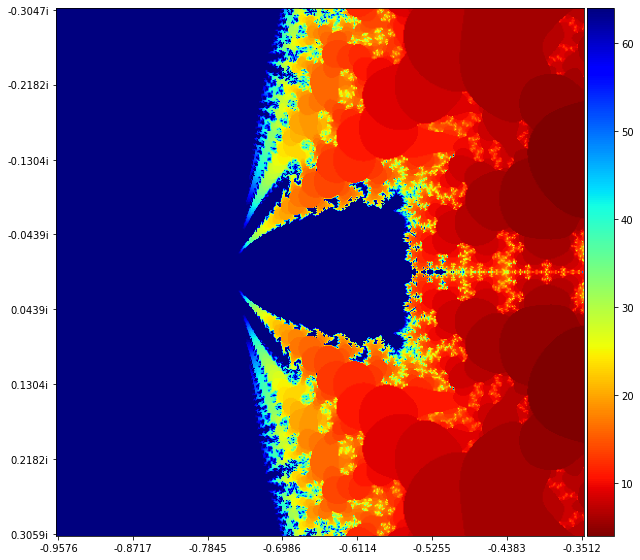

In [200]:
xmin, xmax, ymin, ymax = -.96, -.35, -.3071, .3071

plot_mandelbrot_function (cos_mandelbrot, xmin,xmax,ymin,ymax,shading=False,
                          color_map_index=-2,save=False)

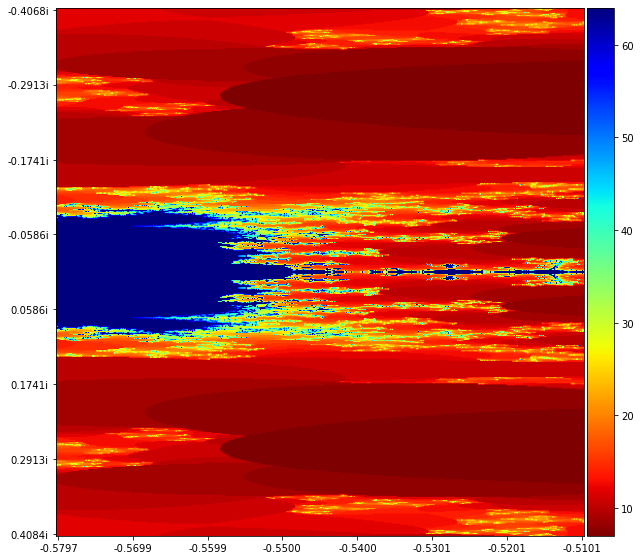

In [192]:
# blood red cloud scape shading=False,color_map_index=-2
xmin, xmax, ymin, ymax = -.58,-.51, -.41,.41
# hand scraping nails across sky shading=False,color_map_index=0
plot_mandelbrot_function (cos_mandelbrot, xmin,xmax,ymin,ymax,shading=False, color_map_index=-2,
                        save=False)

<ipython-input-185-90ae3013353d>:8: RuntimeWarning: overflow encountered in cos
  X = np.cos(X/C)


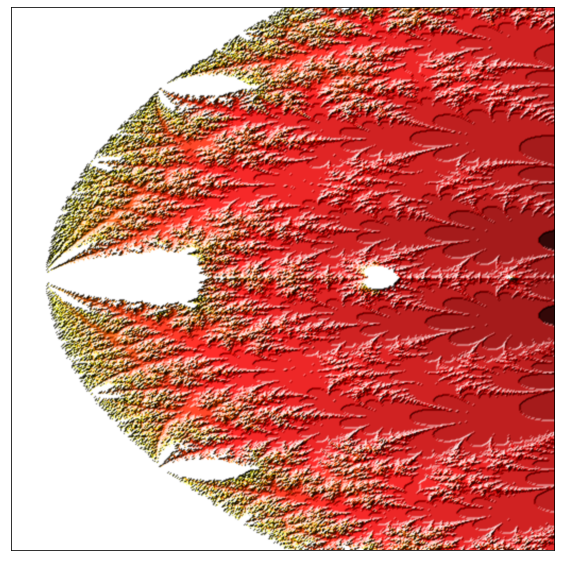

In [209]:
#xmin, xmax, ymin, ymax = -.75,-.29, -.8,.8
xmin, xmax, ymin, ymax = -.8,-.1, -.8,.8
save= False
#color_map_index,max_iter, b,shading,log_mapping = -3, 64, 2.,False,False
# The next us quite spectacular in texture,  suggesting that closer in gets more texture.
shading_color_map_index,max_iter, b,shading,log_mapping = -1, 200,2.0**40,True,False
plot_mandelbrot__function (cos_mandelbrot, xmin,xmax,ymin,ymax,shading=shading, xy_ticks=False,
                        save=save,color_bar=False,color_map_index=color_map_index,
                        shading_color_map_index=shading_color_map_index,
                        max_iter=max_iter,b=b,log_mapping=log_mapping)

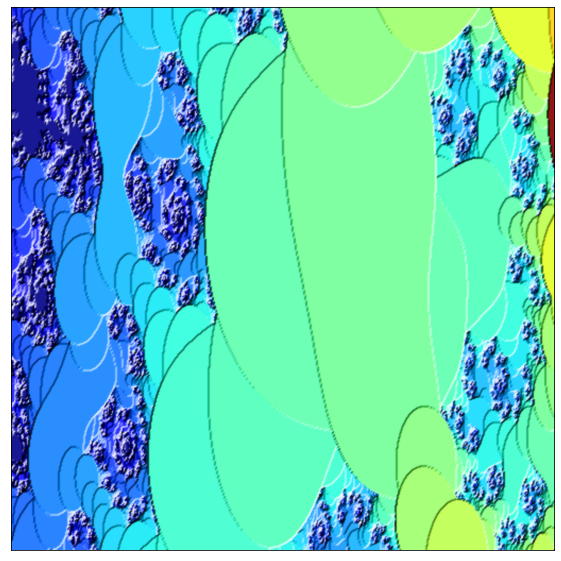

In [155]:
#kinda nice
#xmin, xmax, ymin, ymax = -.7186, -.6786, -.15, -.2682
# eerie, would like to rotate
xmin, xmax, ymin, ymax = -.7186, -.64, .15, .19
#shading_color_map_index = 0
plot_mandelbrot__function (cos_mandelbrot, xmin,xmax,ymin,ymax,color_bar=False,shading=True,
                        xy_ticks=False,save=True,shading_color_map_index = -2)

Same zoom region.

Changing to another color map, we get a 3D effect, because of sharper boundaries
between the color layers.

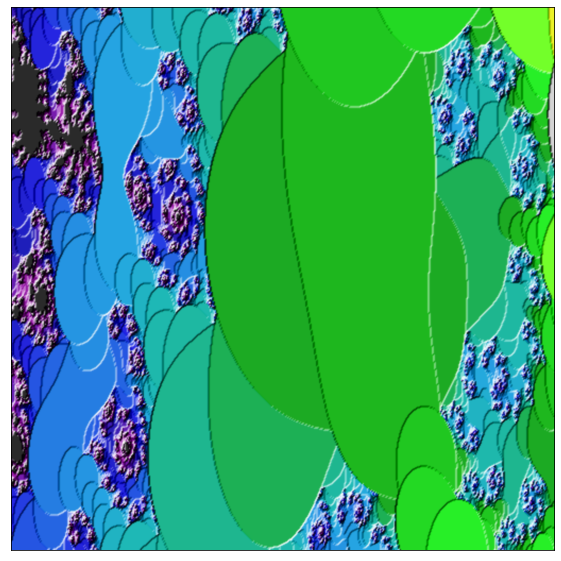

In [169]:
xmin, xmax, ymin, ymax = -.7186, -.64, .15, .19
#shading_color_map_index = 0
plot_mandelbrot__function (cos_mandelbrot, xmin,xmax,ymin,ymax,shading=True,
                        xy_ticks=False,save=True,shading_color_map_index = -3)

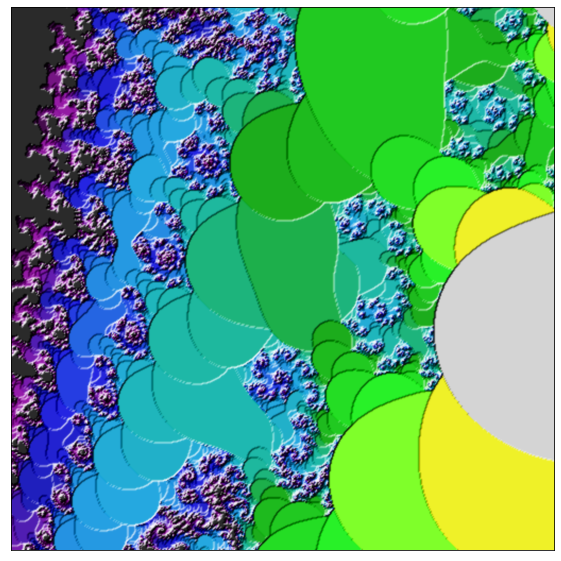

In [171]:
xmin, xmax, ymin, ymax = -.7386, -.62, .11, .23
# Not a lot of diff
#xmin, xmax, ymin, ymax = -.7286, -.61, .11, .23
#shading_color_map_index = 0
plot_mandelbrot__function (cos_mandelbrot, xmin,xmax,ymin,ymax,shading=True,
                        xy_ticks=False,save=False,shading_color_map_index = -3)

This one is ugly, I guess, but strangely iunteresting.  Getting some pinwheel structure.

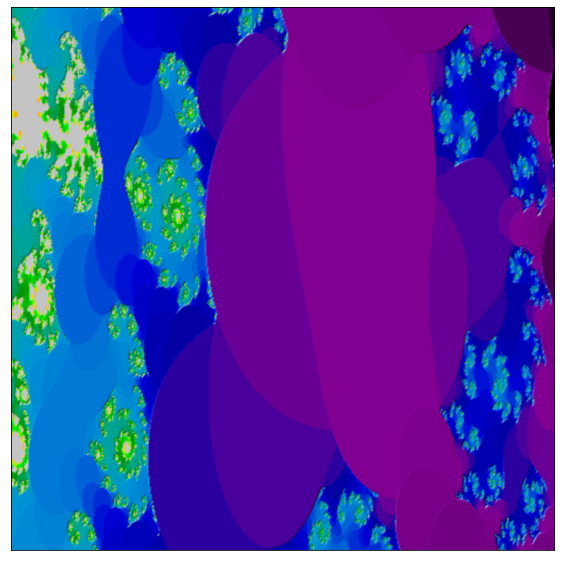

In [212]:
xmin, xmax, ymin, ymax = -.7186, -.64, .15, .19
#shading_color_map_index = 0
plot_mandelbrot__function (cos_mandelbrot, xmin,xmax,ymin,ymax,shading=True,
                        xy_ticks=False,save=True,shading_color_map_index = -3,
                       log_mapping= True)

## Quintic Mandelbrot

In [ ]:
def cos_fifth_mandelbrot(C, max_iter,b=2.): 
  """
  Of course created this function quite by accident, trying
  to make a quintic
  """
  X = C 
  for n in range(max_iter): 
    if abs(X) > b: 
      return n 
    X = np.cos(X/C)**5
    #X = X**5/C
  return max_iter 

def quintic_cos_mandelbrot(C, max_iter,b=2.): 
  """
  Of course created this function quite by accident, trying
  to make a quintic
  """
  X = C 
  for n in range(max_iter): 
    if abs(X) > b: 
      return n 
    X = np.cos(X**5/C)
    #X = X**5/C
  return max_iter 

<ipython-input-254-3f680a92c744>:23: RuntimeWarning: overflow encountered in cos
  X = np.cos(X**5/C)


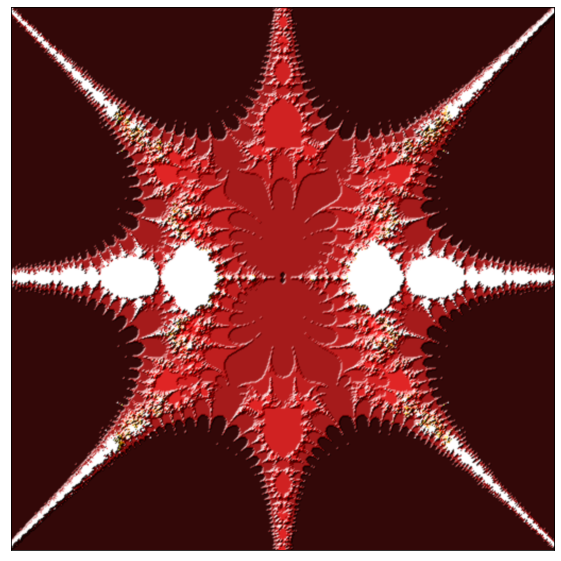

In [254]:
#xmin, xmax, ymin, ymax = -1.27, 1.27, -1.93, 1.93
#xmin, xmax, ymin, ymax = -1.5, 1.5, -1.93, 1.93
# Seems to give the nicest man of thorns pic
xmin, xmax, ymin, ymax = -1.9, 1.9, -1.93, 1.93
#xmin, xmax, ymin, ymax = -2.5, 2.5, -1.93, 1.93
# To try # without log map lots of overflow warnings and a cool pic
# With log map also cool; default shaded color map (-1) works, also -2
save = True

# the man of thorns
func = quintic_cos_mandelbrot
# Loses all texture on man of thorns
#max_iter,b,shading_color_map_index,log_mapping,shading = 200,2.0**40,-1,True,True
max_iter,b,shading_color_map_index,log_mapping,shading = 200,2.0**40,-1,False,True
# only woprkks with color map -2, structure blurred
#max_iter,b,log_mapping,shading,color_map_index = 64,2.,False,False,-2
plot_mandelbrot_function (func, xmin,xmax,ymin,ymax,shading=shading,
                        color_map_index=color_map_index, save = save,
                        shading_color_map_index = shading_color_map_index,
                        max_iter=max_iter,b=b,log_mapping=log_mapping)

<ipython-input-254-3f680a92c744>:10: RuntimeWarning: overflow encountered in cdouble_scalars
  X = np.cos(X/C)**5
<ipython-input-254-3f680a92c744>:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  X = np.cos(X/C)**5
<ipython-input-254-3f680a92c744>:10: RuntimeWarning: overflow encountered in cos
  X = np.cos(X/C)**5


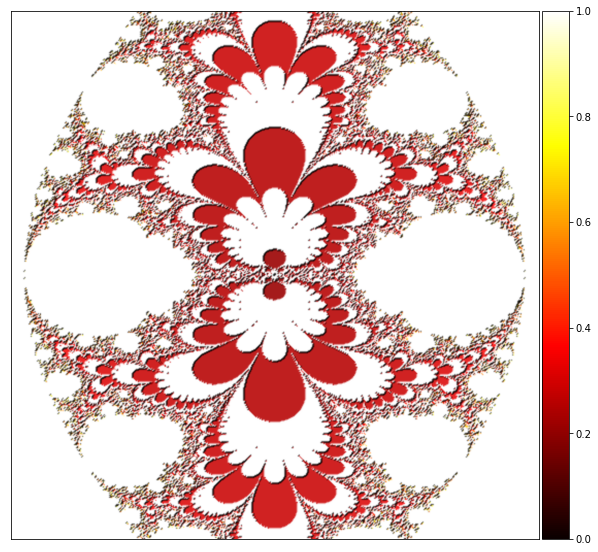

In [461]:
#xmin, xmax, ymin, ymax = -1.27, 1.27, -1.93, 1.93
xmin, xmax, ymin, ymax = -1.5, 1.5, -1.93, 1.93
# Seems to give the nicest pic
#xmin, xmax, ymin, ymax = -1.9, 1.9, -1.93, 1.93
#xmin, xmax, ymin, ymax = -2.5, 2.5, -1.93, 1.93
# This time the max value makes a huge difference 2**40 comletely different from 2**2
max_iter,b,shading_color_map_index,log_mapping,shading = 200,2.0**40,-1,False,True

# the double bird
func = cos_fifth_mandelbrot
# only woprkks with color map -2, structure blurred
#max_iter,b,log_mapping,shading,color_map_index = 64,2.,False,False,-2
plot_mandelbrot_function (func, xmin,xmax,ymin,ymax,shading=shading,
                        color_map_index=color_map_index, save = save,
                        shading_color_map_index = shading_color_map_index,
                        max_iter=max_iter,b=b,log_mapping=log_mapping)


In [505]:
z = complex(145,145)
np.angle(z)

0.7853981633974483

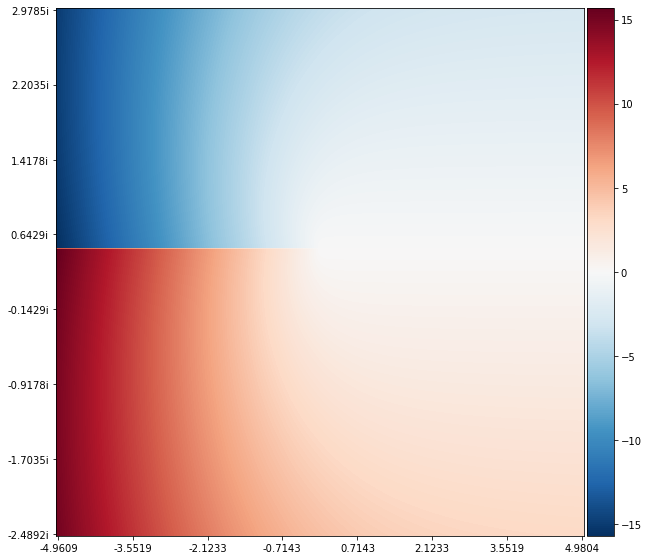

In [504]:
import matplotlib as mpl

def cos (C,max_iter,b=2.,f=2**32):
    return np.abs(np.sin(C))

def z_over_i (C):
    #return np.angle(i/C - C/i)
    #z = np.angle(i/C - C/i)
    z = C
    return np.abs(z)* np.angle(z)
    
max_iter,b,shading_color_map_index,log_mapping,shading = 1,2.0,0,False,False

# the double bird
func = z_over_i
# only woprkks with color map -2, structure blurred
#max_iter,b,log_mapping,shading,color_map_index = 64,2.,False,False,0
xmin,xmax,yjmin,ymax = -5,5,-1,3
plot_complex_function (func, xmin,xmax,ymin,ymax,shading=shading,
                        color_map_index=color_map_index, save = save,
                        shading_color_map_index = shading_color_map_index,
                        max_iter=max_iter,b=b,log_mapping=log_mapping)


## Visualizing a color map on its own

The following code divides a color map into a hundred steps and displays the color associated with
each, starting in the upper left hand corner with the lowest value in the map and working left to right,
then top to botTom toward the lower right hand corner, like so:

```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
 [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
 [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]
```

By default, `imshow` normalizes the color map it is given to fit (`vmin`, `vmax`), the min and max values in the value set. See [Matplotlib color normalization docs.](https://matplotlib.org/3.1.1/tutorials/colors/colormapnorms.html)

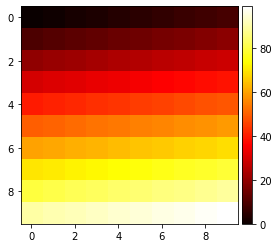

In [294]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

#cmap = cm.nipy_spectral_r
cmap = cm.hot
ax = plt.subplot(111)
im = ax.imshow(np.arange(100).reshape((10, 10)),cmap=cmap)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

### Appendix:  Mandelbrot set details

Helpful in constructing this NB:
    

1. Alexander Devert's [Matplotlib Plotting Cookbook](https://www.amazon.com/gp/product/1849513260?ref=em_1p_0_ti&ref_=pe_2313400_557320840)
2. [Real Python Guide on String formatting](https://realpython.com/python-formatted-output/)
3. [Matplotlib Image Tutorial](https://matplotlib.org/3.1.1/tutorials/introductory/images.html#sphx-glr-tutorials-introductory-images-py)

Some sample values from the picture

In [37]:
def format_f (C,p=2):
    fill_value = 7 + 2*p
    return f'{C:{fill_value}.{p}f}'

xmin, xmax, ymin, ymax,N,max_iter = -2.2, .8, -1.5, 1.5, 512,64
X = np.linspace(xmin, xmax, N) 
Y = np.linspace(ymin, ymax, N) 
    
new_x,new_y = X[257], Y[200]
print(1, f'Mandelbrot val of {format_f(complex(new_x,new_y)): >11}: {iter_mandelbrot(complex(new_x,new_y),max_iter): >2}')
new_x2,new_y2 = new_x, .64 
print(2, f'Mandelbrot val of {format_f(complex(new_x2,new_y2)): >11}: {iter_mandelbrot(complex(new_x2,new_y2),max_iter): >2}')
print()
print(4, f'Mandelbrot val of {format_f(complex(.8,-.1)): >11}: {iter_mandelbrot(complex(.8,-.1),max_iter): >2}')
print(5, f'Mandelbrot val of {format_f(complex(-.1,.8)): >11}: {iter_mandelbrot(complex(-.1,.8),max_iter): >2}')


1 Mandelbrot val of -0.69-0.33j: 64
2 Mandelbrot val of -0.69+0.64j:  5

4 Mandelbrot val of  0.80-0.10j:  2
5 Mandelbrot val of -0.10+0.80j: 64


Finding values in Z.

In [ ]:
# The rule:  The row idx in Z is the imaginary coordinate, 
# the col idx is the real coordinate,  
# X and Y are matrices giving the X and Y coordinates of
# points in C to be mandelbrot-mapped (x + yi)
max_iter = 64
Z = compute_mandelbrot_matrix(X, Y, max_iter)

**Or** use another function.

In [317]:
max_iter,N1 = 64,64
# Include point -2.2 + -2.1i (just outside circle of radius 2)
xmin,xmax,ymin,ymax = -2.2,2.1,-2.1,2.1
X = np.linspace(xmin, xmax, N1) 
Y = np.linspace(ymin, ymax, N1) 

Z= compute_matrix_for_mandelbrot_func(sin_mandelbrot, X, Y, max_iter,b=2**2)

In [318]:
Y[0],X[0],Z[0,0]

(-2.1, -2.2, 64)

In [316]:
sin_mandelbrot(complex(-2.1,-2.2),200,2**2)

200

In [86]:
def print_vals(i,j,x,y):
    mand_i = iter_mandelbrot(complex(X[x],Y[y]),max_iter)
    print(f"{Z[i][j]: >2d} {X[x]:>.3f} {Y[y]:> .3f}i {mand_i: >2d}")

i,j,x,y = 20,100,100,20
print_vals(i,j,x,y)
print_vals(j,i,x,y)

 9 -0.841  0.283i  9
64 -0.841  0.283i  9


### Following the sequence generated by one C   (for a while)

Recall the basic recursion relation

```
X = X**2 + C
```

Fixing `C` and looking at successive iteration values for`X`, 
we show a case where the absolute value
of `X` circles in the neighborhood of two different values depending on whether the iteration number is odd or even. That is, the recursion is bounded
and this point falls into the Mandelbrot set.

There appears to be evidence of convergence here, in that the distance between  successive odd/even  values goes down (the column labeled "Delta" below); 

The Mandelbrot point below is

$$C = -1.1 + 0.05i$$


Starting from there, the even numbered Xs spiral round some value very close to

$$
X_{i} =  .0931 - 0.0422i,
$$


growing closer over time. Hence the name **sink**; meanwhile the odd numbered
values spiral round

$$
X_{i+1} = -1.0931i +0.0422i. 
$$



In [438]:
C = complex(-1.1,0.05)
X1 = complex(.0931,-0.0422)
X2 = X1**2 + C
X3 = X2**2 + C

print(format_f (X1,p=.3,inc=2),']->',format_f (X2,p=.3,inc=2),']->',\
      format_f (X3,p=.3,inc=2))

 0.093-0.042j ]-> -1.093+0.042j ]->  0.093-0.042j


In [462]:
def format_f (C,p=.3,inc=2):
    fill_value=inc+p
    return f'{C: {fill_value}f}'

def format_complex(C,p=.3,width=2):
    return f'{C.real: {width+p}f}{C.imag:+{width+p}f}i'

def one_iter_mandelbrot(X0, C, p=.3, iter_num = None,i=None,mod_val=2,
                        delta_str = ''): 
  iter_num = '' if iter_num is None else iter_num
  X = X0 ** 2 + C 
  if i is not None and i%mod_val == 0:
    delta_str = f'{np.abs(X - vals[-mod_val]):.6f}'
  print(f'{iter_num: >3} {format_complex(X,p=p,width=3)}  {delta_str}')
  return X

# A mandelbrot point
outer_val = complex(-1.1,0.05)
# A mandelbrot point that converges more slowly (set max iter 128)
#outer_val = complex(-1.0,0.2)
# A point that diverges (set max_iter 64)
#outer_val = complex(-1.0,0.3)
# Another  point that diverges
#outer_val = complex(-.8,0.9)
X, C,this_max_iter = outer_val, outer_val,32
#X, C,this_max_iter = outer_val, outer_val,128
vals = [0,0]
print(f'{"":22} Delta')
for i,n in enumerate(range(this_max_iter)):
    X = one_iter_mandelbrot(X, C, p=.4, iter_num=n, i=i)
    vals.append(X)
    


                       Delta
  0  0.1075-0.0600i  0.123111
  1 -1.0920+0.0371i  
  2  0.0912-0.0310i  0.033249
  3 -1.0926+0.0443i  
  4  0.0919-0.0469i  0.015886
  5 -1.0938+0.0414i  
  6  0.0946-0.0405i  0.006917
  7 -1.0927+0.0423i  
  8  0.0922-0.0425i  0.003117
  9 -1.0933+0.0422i  
 10  0.0935-0.0422i  0.001394
 11 -1.0930+0.0421i  
 12  0.0929-0.0420i  0.000623
 13 -1.0931+0.0422i  
 14  0.0932-0.0422i  0.000279
 15 -1.0931+0.0421i  
 16  0.0931-0.0421i  0.000125
 17 -1.0931+0.0422i  
 18  0.0931-0.0422i  0.000056
 19 -1.0931+0.0421i  
 20  0.0931-0.0421i  0.000025
 21 -1.0931+0.0422i  
 22  0.0931-0.0422i  0.000011
 23 -1.0931+0.0422i  
 24  0.0931-0.0422i  0.000005
 25 -1.0931+0.0422i  
 26  0.0931-0.0422i  0.000002
 27 -1.0931+0.0422i  
 28  0.0931-0.0422i  0.000001
 29 -1.0931+0.0422i  
 30  0.0931-0.0422i  0.000000
 31 -1.0931+0.0422i  
